# Granular Demand Forecast

In [2]:
import os
import yaml
import datetime
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import psycopg2
import pandas as pd
import numpy as np
import urllib.request
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
from sqlalchemy import text
from sqlalchemy import create_engine

In [3]:
# setting WD
os.chdir('/Users/Daniel.Kwon/projects')

In [4]:
# database connection info
with open("./redshift_credentials.yml", 'r') as stream:
    try:
        rs_cred = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
engine_url = "postgresql://{user_name}:{pw}@{host}:{port}/{db_name}".format(user_name = rs_cred['default']['user'],
                                                                            pw        = urllib.parse.quote_plus(rs_cred['default']['password']),
                                                                            host      = rs_cred['default']['host'],
                                                                            port      = rs_cred['default']['port'],
                                                                            db_name   = rs_cred['default']['dbname']
                                                                           )
engine = create_engine(engine_url)

In [5]:
# query
query = open('./granular-demand-forecast/sql/rug_sales.sql', 'r')
query_text = text(query.read())
df_sales = pd.read_sql_query(query_text, engine)

# get ad spend
df_spend = pd.read_csv('./granular-demand-forecast/data/ad_spend.csv')

# get marketing events
df_event = pd.read_csv('./granular-demand-forecast/data/marketing_events.csv')

# merge df
df_spend['week_begin_date']=pd.to_datetime(df_spend['week_begin_date'])
df_event['week_begin_date']=pd.to_datetime(df_event['week_begin_date'])
df_sales['week_begin_date']=pd.to_datetime(df_sales['week_begin_date'])
df_sales = df_sales.merge(df_spend, how='inner', on='week_begin_date')
df_sales = df_sales.merge(df_event, how='inner', on='week_begin_date')

In [6]:
df_sales.tail()

,week_begin_date,quantity,total_rugs_sold,percent_of_total,num_days,total_weekly_spend,sale,launch,email,bfcm,...,"6"" Round","8"" Round",doormat,2x3,3x5,5x7,6x9,8x10,9x12,outdoor
140,2021-09-13,48573,48573,1.0,7,2.429606e+06,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
141,2021-09-20,49358,49358,1.0,7,2.527968e+06,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142,2021-09-27,52776,52776,1.0,7,2.533569e+06,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143,2021-10-04,50380,50380,1.0,7,2.293768e+06,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
144,2021-10-11,55826,55826,1.0,7,2.205000e+06,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creating Top Line Forecast

Forecast total number of rugs for use as inputs for other forecasts

In [7]:
df = df_sales[['week_begin_date',
               'total_rugs_sold',
               'total_weekly_spend',
               'sale',
               'launch',
               'bfcm',
               'anniversary',
               'spring',
               'nynh',
               'memorial_day',
               'email',
               'test'
              ]].rename(columns={'week_begin_date':'ds',
                                 'total_rugs_sold':'y'})

In [8]:
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.05)

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_weekly_spend',mode='multiplicative')
m.add_regressor('sale')
m.add_regressor('launch')
m.add_regressor('bfcm')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df)

# cross validate
df_cv = cross_validation(m, initial='110 W', period='4 W', horizon = '4 W')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 8 forecasts with cutoffs between 2021-03-01 00:00:00 and 2021-09-13 00:00:00


Initial log joint probability = -2.7349
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       355.389      0.035387       154.085           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       361.608   3.26764e-06       81.4667      0.3576      0.3576      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       361.617     0.0001213       69.1584   1.153e-06       0.001      331  LS failed, Hessian reset 
     299       361.626   1.13932e-08       73.3837      0.3327      0.3327      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       361.626    9.5509e-09       67.0123      0.2935      0.2935      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  0%|          | 0/8 [00:00<?, ?it/s]

Initial log joint probability = -2.42375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       350.619    0.00512093       173.256      0.8253      0.8253      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121        351.39   7.82877e-05       77.6886   7.228e-07       0.001      203  LS failed, Hessian reset 
     199       352.154    0.00357879       135.974           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       352.437   0.000270656       76.9517    4.24e-06       0.001      373  LS failed, Hessian reset 
     282        352.49   2.77903e-05       73.0081   4.069e-07       0.001      482  LS failed, Hessian reset 
     299       352.498   0.000108861       89.4589           1           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,1.158467e+08,10763.209169,9657.622652,0.197539,0.237713,0.197892,0.250
1,14 days,1.074345e+08,10365.060568,8515.182498,0.182643,0.168272,0.177102,0.375
2,21 days,8.853626e+07,9409.370985,8924.655400,0.206493,0.230427,0.197892,0.375
3,28 days,1.765137e+09,42013.538752,23000.012768,0.299608,0.259778,0.333977,0.250


In [10]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_spend, 
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_event,
                      left_on='ds', right_on='week_begin_date')
forecast = m.predict(future)

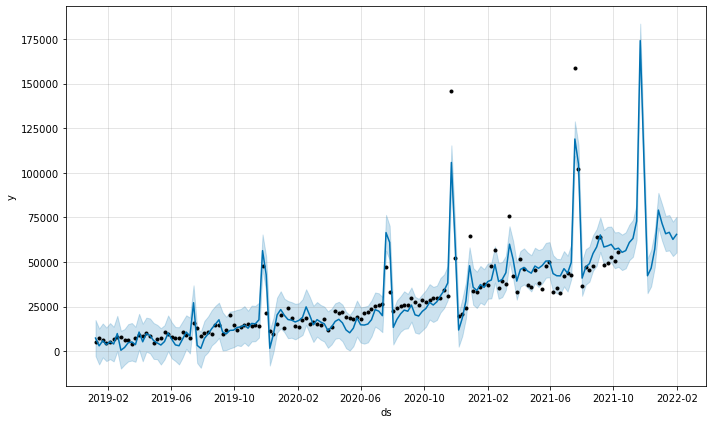

In [11]:
fig = m.plot(forecast)

In [12]:
df_topline = forecast[['ds', 'yhat']]
df_topline = df_topline.merge(df[['ds','y']], how='left', on='ds')
df_topline['merged_total_rugs'] = df_topline.y.combine_first(df_topline.yhat)
df_topline = df_topline.rename(columns={'yhat':'forecasted_total_rugs',
                                        'y':'actual_total_rugs'})

## Indoor / Outdoor Chenille (to be used as inputs for granular forecasts)

In [23]:
# function + texture
query = open('./granular-demand-forecast/sql/rug_sales_function-texture.sql', 'r')
query_text = text(query.read())
df_sales_FT = pd.read_sql_query(query_text, engine)
df_sales_FT['week_begin_date']=pd.to_datetime(df_sales_FT['week_begin_date'])
df_sales_FT = df_sales_FT.merge(df_event, how='inner', on='week_begin_date')

In [24]:
df_sales_FT.tail()

,week_begin_date,function,texture,quantity,total_rugs_sold,percent_of_total,num_days,sale,launch,email,...,"6"" Round","8"" Round",doormat,2x3,3x5,5x7,6x9,8x10,9x12,outdoor
529,2021-10-11,Indoor,Chenille,47835,55812,0.857074,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
530,2021-10-11,Indoor,Plush,1199,55812,0.021483,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
531,2021-10-11,NUL,Rubber pad,1107,55812,0.019834,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
532,2021-10-11,Outdoor,Chenille,1145,55812,0.020515,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
533,2021-10-11,Outdoor,Jute,1150,55812,0.020605,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Indoor Chenille - % of Total

In [25]:
df = df_sales_FT.loc[(df_sales_FT['function']=='Indoor') &
                     (df_sales_FT['texture']=='Chenille')].rename(columns={'week_begin_date': 'ds',
                                                                           'percent_of_total': 'y'})
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False)

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df)

# CV resulting model
df_cv = cross_validation(m, initial='110 W', period='1 W', horizon = '12 W')

# forecast future values
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event,
                      left_on='ds',
                      right_on='week_begin_date')
future = future.merge(df_topline, on='ds').rename(columns={'merged_total_rugs': 'total_rugs_sold'})
forecast = m.predict(future)

INFO:prophet:Making 23 forecasts with cutoffs between 2021-02-15 00:00:00 and 2021-07-19 00:00:00


Initial log joint probability = -2.04625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       576.873   0.000392645       159.134      0.7363      0.7363      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       578.402   0.000126653       171.199   1.445e-06       0.001      289  LS failed, Hessian reset 
     199       578.423    7.7077e-05       63.0247       0.947       0.947      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       578.972   5.06189e-05       51.5016      0.2178           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       579.032   1.32168e-06       61.3712      0.3253           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       579.109   4.43564e-05    

  0%|          | 0/23 [00:00<?, ?it/s]

Initial log joint probability = -2.03386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.609     0.0010028       232.022           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       467.771   0.000368503       175.308           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       467.922   0.000422636       173.622       4.633      0.4633      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     392       468.082   0.000248657       132.958   2.567e-06       0.001      522  LS failed, Hessian reset 
     399       468.117   0.000344002       100.676           1           1      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       468.181   1.62142e-05    

In [26]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,14 days,0.000420,0.020502,0.016705,0.019226,0.016817,0.019153,0.454106
1,21 days,0.000407,0.020162,0.016386,0.018787,0.017888,0.018799,0.471820
2,28 days,0.000441,0.021008,0.017290,0.019785,0.013578,0.019852,0.441224
3,35 days,0.000502,0.022410,0.018124,0.020736,0.013588,0.020826,0.471820
4,42 days,0.000530,0.023016,0.018686,0.021358,0.014007,0.021466,0.404187


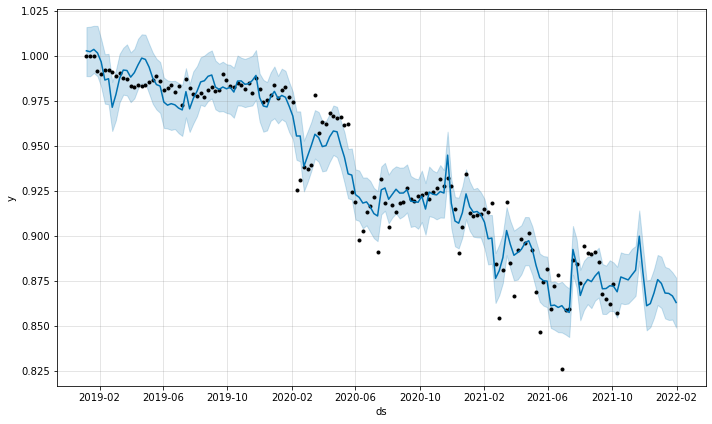

In [27]:
fig = m.plot(forecast)

In [28]:
df_IndoorChenille = forecast[['ds', 'yhat']]
df_IndoorChenille = df_IndoorChenille.merge(df[['ds','y']], how='left', on='ds')
df_IndoorChenille['y_merged'] = df_IndoorChenille.y.combine_first(df_IndoorChenille.yhat)
df_IndoorChenille = df_IndoorChenille.rename(columns={'yhat':'forecast',
                                                      'y':'actual',
                                                      'y_merged':'merged'})
df_IndoorChenille['function'] = 'Indoor'
df_IndoorChenille['texture'] = 'Chenille'

### Outdoor Chenille - % of Total

In [29]:
df = df_sales_FT.loc[(df_sales_FT['function']=='Outdoor') &
                     (df_sales_FT['texture']=='Chenille')].rename(columns={'week_begin_date':'ds',
                                                                           'percent_of_total':'y'})
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.06,
            growth='flat')

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')
m.add_regressor('outdoor')

# train model
m.fit(df)

# CV resulting model
df_cv = cross_validation(m, initial='52 W', period='8 W', horizon = '12 W')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 2 forecasts with cutoffs between 2021-05-24 00:00:00 and 2021-07-19 00:00:00



Initial log joint probability = -154.928
Iteration  1. Log joint probability =    52.7313. Improved by 207.659.
Iteration  2. Log joint probability =    71.0843. Improved by 18.353.
Iteration  3. Log joint probability =    158.269. Improved by 87.1843.
Iteration  4. Log joint probability =    169.088. Improved by 10.8192.
Iteration  5. Log joint probability =    169.147. Improved by 0.0596672.
Iteration  6. Log joint probability =    169.446. Improved by 0.298829.
Iteration  7. Log joint probability =    169.446. Improved by 4.66038e-07.
Iteration  8. Log joint probability =    169.446. Improved by 3.61572e-07.
Iteration  9. Log joint probability =    169.446. Improved by 2.80521e-07.
Iteration 10. Log joint probability =    169.446. Improved by 2.17636e-07.
Iteration 11. Log joint probability =    169.446. Improved by 1.68848e-07.
Iteration 12. Log joint probability =    169.446. Improved by 1.30996e-07.
Iteration 13. Log joint probability =    169.446. Improved by 1.01629e-07.
Itera

  0%|          | 0/2 [00:00<?, ?it/s]


Initial log joint probability = -136.332
Iteration  1. Log joint probability =    40.2544. Improved by 176.586.
Iteration  2. Log joint probability =    77.3372. Improved by 37.0828.
Iteration  3. Log joint probability =    108.323. Improved by 30.9862.
Iteration  4. Log joint probability =    134.638. Improved by 26.3142.
Iteration  5. Log joint probability =    135.842. Improved by 1.20407.
Iteration  6. Log joint probability =    138.411. Improved by 2.5696.
Iteration  7. Log joint probability =    138.475. Improved by 0.0637233.
Iteration  8. Log joint probability =    138.711. Improved by 0.235586.
Iteration  9. Log joint probability =    138.734. Improved by 0.0236937.
Iteration 10. Log joint probability =    139.149. Improved by 0.415203.
Iteration 11. Log joint probability =    139.327. Improved by 0.177261.
Iteration 12. Log joint probability =    150.425. Improved by 11.098.
Iteration 13. Log joint probability =    150.535. Improved by 0.109821.
Iteration 14. Log joint proba

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.000241,0.015519,0.012662,0.268263,0.268263,0.308064,0.5
1,14 days,0.000064,0.008002,0.007405,0.227367,0.227367,0.195981,0.0
2,21 days,0.000153,0.012382,0.012082,0.352878,0.352878,0.299405,0.0
3,28 days,0.000152,0.012317,0.011923,0.370312,0.370312,0.312369,0.0
4,35 days,0.000214,0.014616,0.013312,0.464963,0.464963,0.372547,0.0


In [30]:
# forecast future values
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event,
                      left_on='ds',
                      right_on='week_begin_date')
future = future.merge(df_topline, on='ds').rename(columns={'merged_total_rugs': 'total_rugs_sold'})
forecast = m.predict(future)

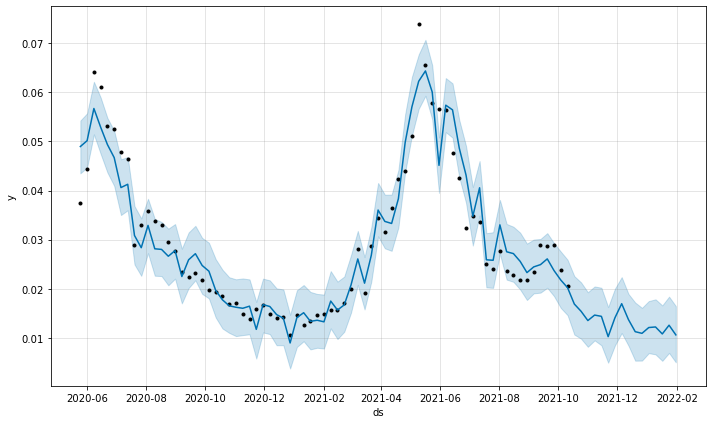

In [31]:
fig = m.plot(forecast)

In [32]:
df_OutdoorChenille = forecast[['ds', 'yhat']]
df_OutdoorChenille = df_OutdoorChenille.merge(df[['ds','y']], how='left', on='ds')
df_OutdoorChenille['y_merged'] = df_OutdoorChenille.y.combine_first(df_OutdoorChenille.yhat)
df_OutdoorChenille = df_OutdoorChenille.rename(columns={'yhat':'forecast',
                                                        'y':'actual',
                                                        'y_merged':'merged'})
df_OutdoorChenille['function'] = 'Outdoor'
df_OutdoorChenille['texture'] = 'Chenille'

In [33]:
df_Chenille = pd.concat([df_IndoorChenille, df_OutdoorChenille])

## Loop Through Sizes

In [34]:
# function + texture + size
query = open('./granular-demand-forecast/sql/rug_sales_function-texture-size.sql', 'r')
query_text = text(query.read())
df_sales_FTS = pd.read_sql_query(query_text, engine)
df_sales_FTS['week_begin_date']=pd.to_datetime(df_sales_FTS['week_begin_date'])
df_sales_FTS = df_sales_FTS.merge(df_event, how='inner', on='week_begin_date')

In [35]:
df_sales_FTS.tail()

,week_begin_date,function,texture,size,quantity,total_rugs_sold,percent_of_total,num_days,sale,launch,...,"6"" Round","8"" Round",doormat,2x3,3x5,5x7,6x9,8x10,9x12,outdoor
2942,2021-10-11,Outdoor,Chenille,9x12,46,55812,0.000824,7,0,0,...,0,0,0,0,0,0,0,0,0,0
2943,2021-10-11,Outdoor,Jute,2.5x10,189,55812,0.003386,7,0,0,...,0,0,0,0,0,0,0,0,0,0
2944,2021-10-11,Outdoor,Jute,2.5x7,283,55812,0.005071,7,0,0,...,0,0,0,0,0,0,0,0,0,0
2945,2021-10-11,Outdoor,Jute,3x5,432,55812,0.007740,7,0,0,...,0,0,0,0,0,0,0,0,0,0
2946,2021-10-11,Outdoor,Jute,5x7,246,55812,0.004408,7,0,0,...,0,0,0,0,0,0,0,0,0,0


INFO:prophet:n_changepoints greater than number of observations. Using 14.


fitting model for Indoor 2x3 Chenille

Initial log joint probability = -35.0374
Iteration  1. Log joint probability =    9.58687. Improved by 44.6243.
Iteration  2. Log joint probability =    19.5533. Improved by 9.96639.
Iteration  3. Log joint probability =    21.6489. Improved by 2.09565.
Iteration  4. Log joint probability =    21.8978. Improved by 0.248898.
Iteration  5. Log joint probability =    22.2228. Improved by 0.324996.
Iteration  6. Log joint probability =    22.5092. Improved by 0.286403.
Iteration  7. Log joint probability =    22.5093. Improved by 4.83422e-05.
Iteration  8. Log joint probability =    22.5093. Improved by 2.81186e-05.
Iteration  9. Log joint probability =    22.5093. Improved by 1.63444e-05.
Iteration 10. Log joint probability =    22.5093. Improved by 9.4956e-06.
Iteration 11. Log joint probability =    22.5093. Improved by 5.51448e-06.
Iteration 12. Log joint probability =    22.5093. Improved by 3.20152e-06.
Iteration 13. Log joint probability =    2

/Users/Daniel.Kwon/opt/anaconda3/lib/python3.8/site-packages/prophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:prophet:n_changepoints greater than number of observations. Using 16.


-------------------------
fitting model for Outdoor 2.5x7 Jute

Initial log joint probability = -55.271
Iteration  1. Log joint probability =    25.8063. Improved by 81.0772.
Iteration  2. Log joint probability =     34.725. Improved by 8.91873.
Iteration  3. Log joint probability =    35.5096. Improved by 0.784632.
Iteration  4. Log joint probability =    35.7595. Improved by 0.249859.
Iteration  5. Log joint probability =    35.7614. Improved by 0.00189662.
Iteration  6. Log joint probability =    35.8032. Improved by 0.0417825.
Iteration  7. Log joint probability =    35.8441. Improved by 0.0409227.
Iteration  8. Log joint probability =    36.1347. Improved by 0.290599.
Iteration  9. Log joint probability =    36.1354. Improved by 0.000664701.
Iteration 10. Log joint probability =    36.1357. Improved by 0.000388737.
Iteration 11. Log joint probability =     36.136. Improved by 0.000226909.
Iteration 12. Log joint probability =    36.1361. Improved by 0.000132252.
Iteration 13. Log 

INFO:prophet:n_changepoints greater than number of observations. Using 15.


-------------------------
fitting model for Outdoor 2.5x10 Jute

Initial log joint probability = -56.5948
Iteration  1. Log joint probability =    26.1621. Improved by 82.7568.
Iteration  2. Log joint probability =    34.5337. Improved by 8.3717.
Iteration  3. Log joint probability =    37.5882. Improved by 3.05446.
Iteration  4. Log joint probability =    37.8636. Improved by 0.275434.
Iteration  5. Log joint probability =    37.9098. Improved by 0.0461546.
Iteration  6. Log joint probability =     38.032. Improved by 0.122162.
Iteration  7. Log joint probability =    38.3735. Improved by 0.341548.
Iteration  8. Log joint probability =    38.4067. Improved by 0.033141.
Iteration  9. Log joint probability =    38.4074. Improved by 0.000761196.
Iteration 10. Log joint probability =     38.408. Improved by 0.000588244.
Iteration 11. Log joint probability =    38.4085. Improved by 0.000454805.
Iteration 12. Log joint probability =    38.4088. Improved by 0.000351782.
Iteration 13. Log joi

INFO:prophet:n_changepoints greater than number of observations. Using 15.


-------------------------
fitting model for Outdoor 3x5 Jute

Initial log joint probability = -56.5855
Iteration  1. Log joint probability =    27.1257. Improved by 83.7113.
Iteration  2. Log joint probability =    37.1351. Improved by 10.0094.
Iteration  3. Log joint probability =    41.2137. Improved by 4.07868.
Iteration  4. Log joint probability =    41.2897. Improved by 0.0759484.
Iteration  5. Log joint probability =    41.3525. Improved by 0.0627793.
Iteration  6. Log joint probability =    41.4138. Improved by 0.0613111.
Iteration  7. Log joint probability =    41.4138. Improved by 5.45236e-07.
Iteration  8. Log joint probability =    41.4138. Improved by 3.16306e-07.
Iteration  9. Log joint probability =    41.4138. Improved by 1.83489e-07.
Iteration 10. Log joint probability =    41.4138. Improved by 1.06437e-07.
Iteration 11. Log joint probability =    41.4138. Improved by 6.17401e-08.
Iteration 12. Log joint probability =    41.4138. Improved by 3.58121e-08.
Iteration 13. L

INFO:prophet:n_changepoints greater than number of observations. Using 15.


-------------------------
fitting model for Outdoor 5x7 Jute

Initial log joint probability = -56.5884
Iteration  1. Log joint probability =     25.612. Improved by 82.2004.
Iteration  2. Log joint probability =    38.6905. Improved by 13.0785.
Iteration  3. Log joint probability =    42.2514. Improved by 3.56089.
Iteration  4. Log joint probability =    42.3317. Improved by 0.0802996.
Iteration  5. Log joint probability =    42.4564. Improved by 0.124677.
Iteration  6. Log joint probability =    42.4564. Improved by 4.83964e-06.
Iteration  7. Log joint probability =    42.4564. Improved by 1.32615e-06.
Iteration  8. Log joint probability =    42.4564. Improved by 3.63189e-07.
Iteration  9. Log joint probability =    42.4564. Improved by 9.94363e-08.
Iteration 10. Log joint probability =    42.4564. Improved by 2.72203e-08.
Iteration 11. Log joint probability =    42.4564. Improved by 7.45081e-09.


INFO:prophet:n_changepoints greater than number of observations. Using 18.


-------------------------
fitting model for Doormat 2x3 Bristle

Initial log joint probability = -52.7277
Iteration  1. Log joint probability =    16.7324. Improved by 69.4601.
Iteration  2. Log joint probability =     27.699. Improved by 10.9666.
Iteration  3. Log joint probability =     35.385. Improved by 7.68604.
Iteration  4. Log joint probability =    38.0052. Improved by 2.62025.
Iteration  5. Log joint probability =    38.4639. Improved by 0.458613.
Iteration  6. Log joint probability =    38.9203. Improved by 0.456405.
Iteration  7. Log joint probability =     38.936. Improved by 0.0157785.
Iteration  8. Log joint probability =    38.9878. Improved by 0.0517098.
Iteration  9. Log joint probability =     39.027. Improved by 0.0392145.
Iteration 10. Log joint probability =    39.0277. Improved by 0.000756963.
Iteration 11. Log joint probability =    39.0283. Improved by 0.000588499.
Iteration 12. Log joint probability =    39.0288. Improved by 0.000457423.
Iteration 13. Log join

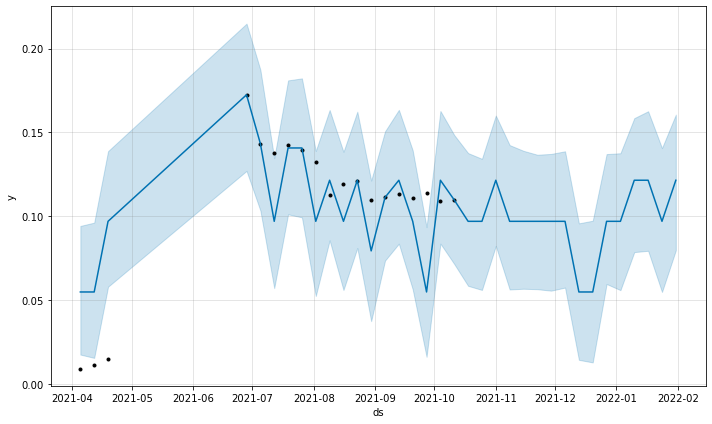

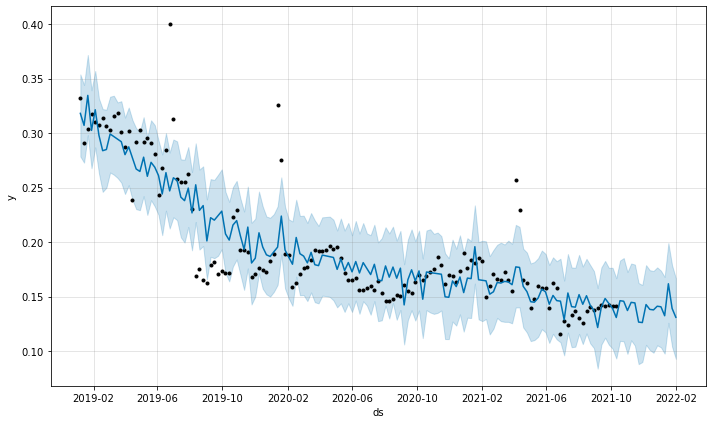

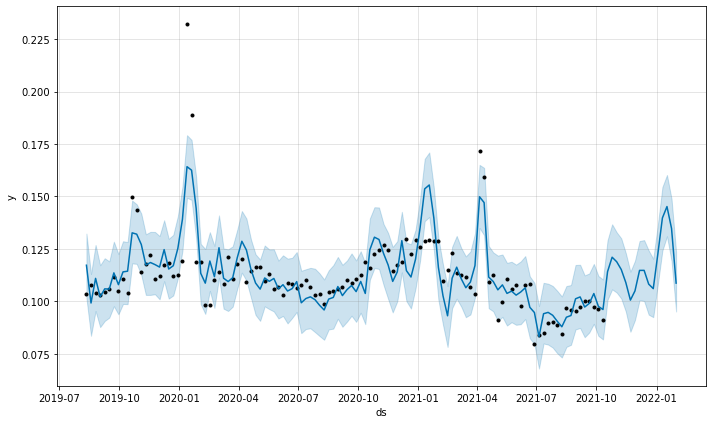

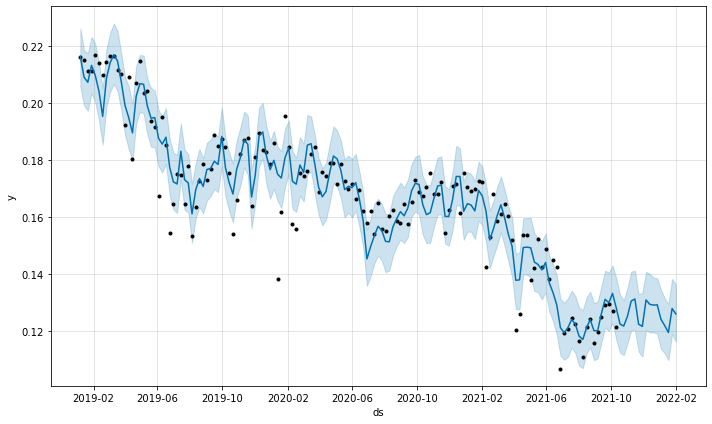

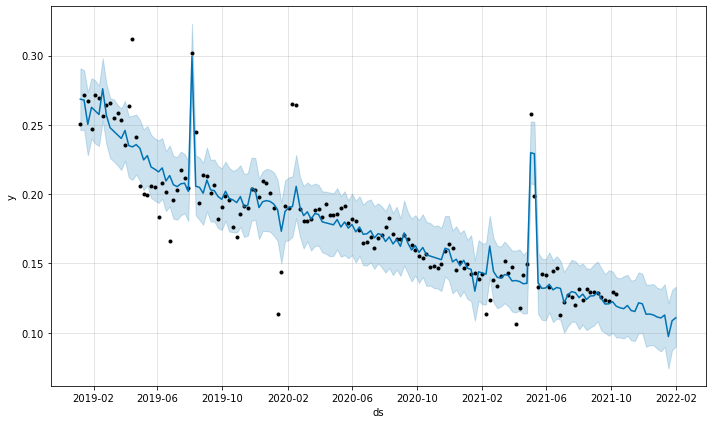

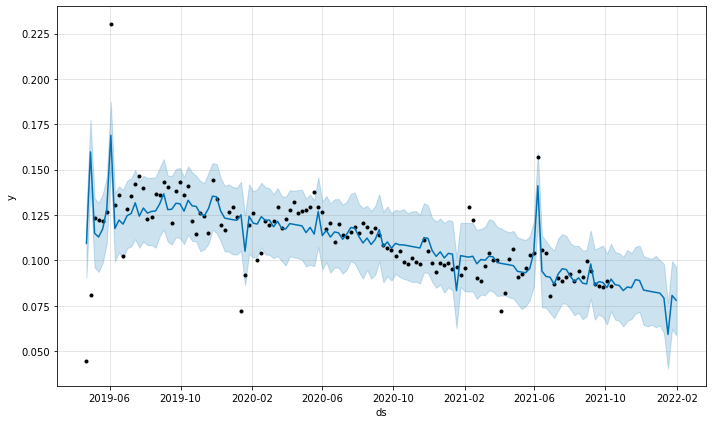

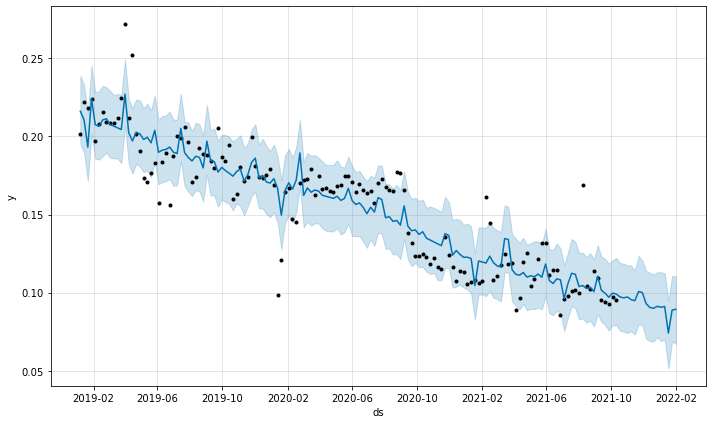

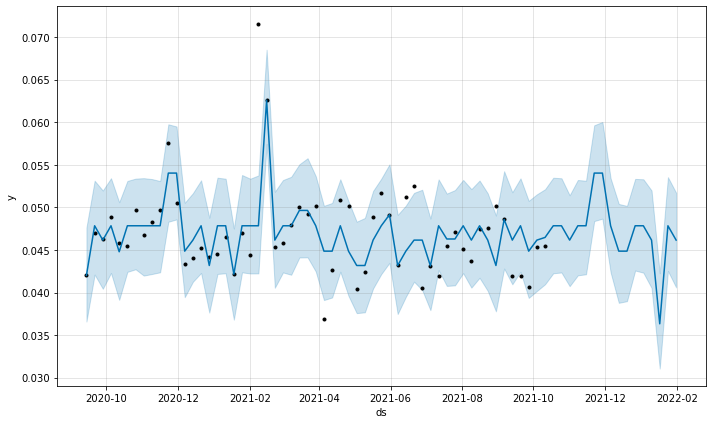

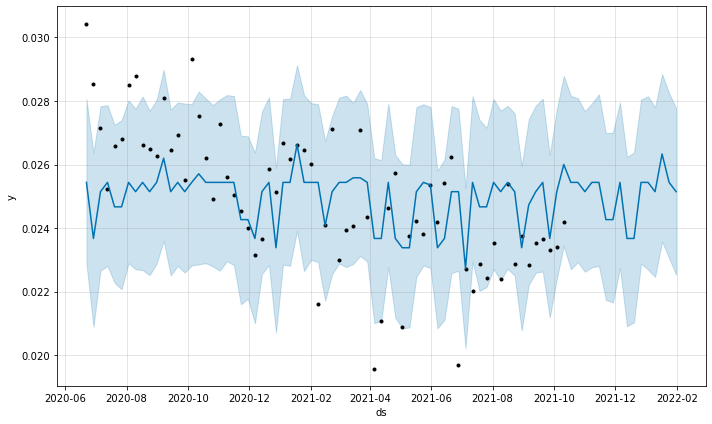

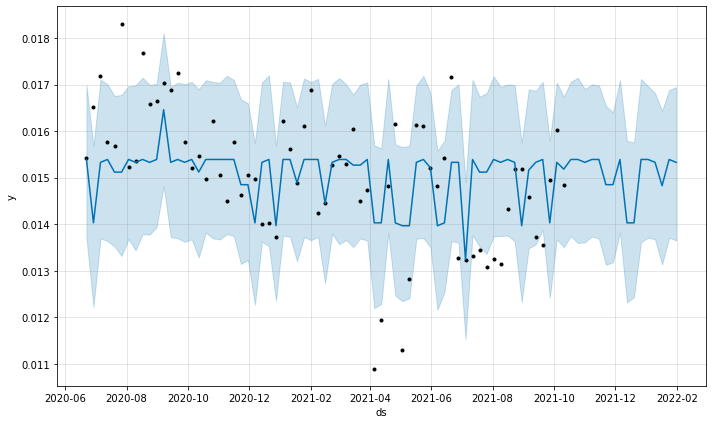

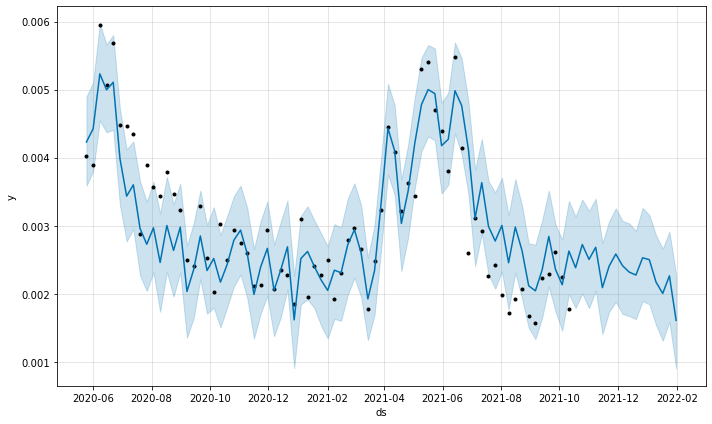

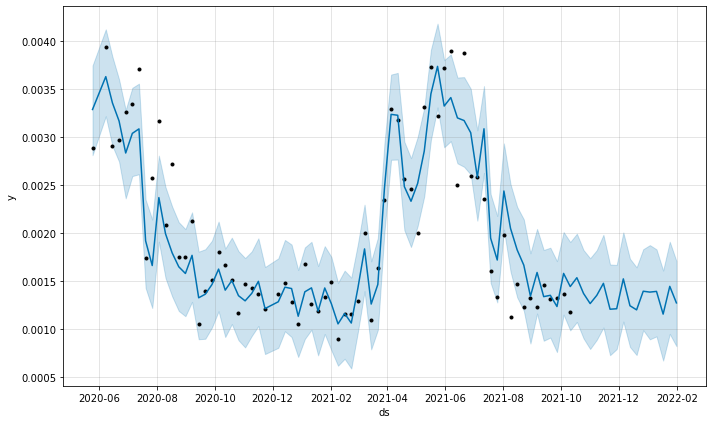

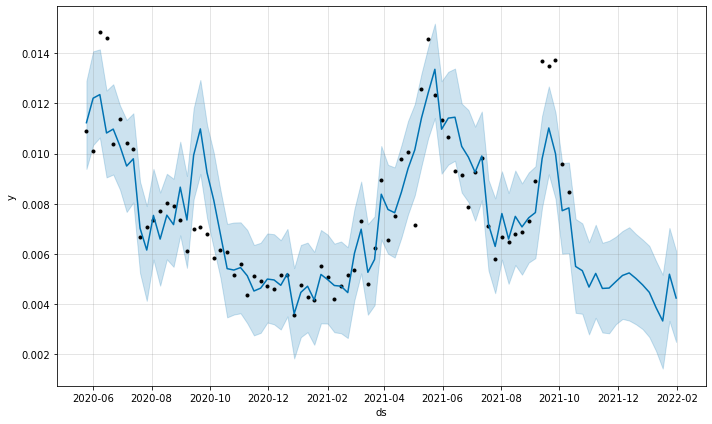

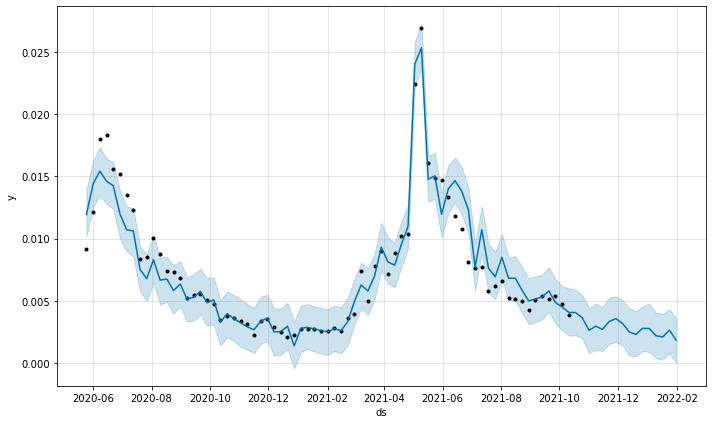

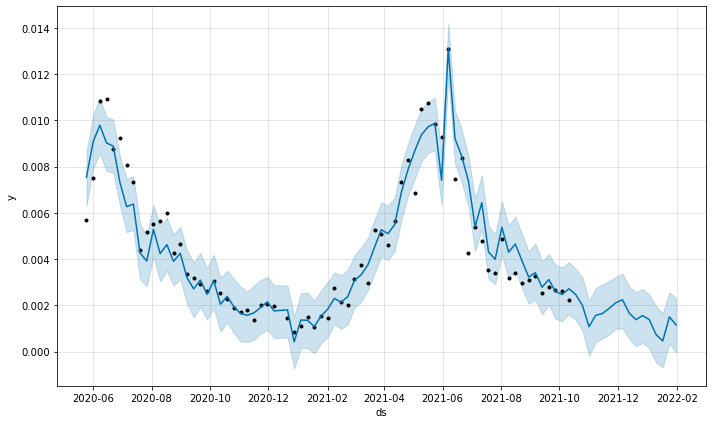

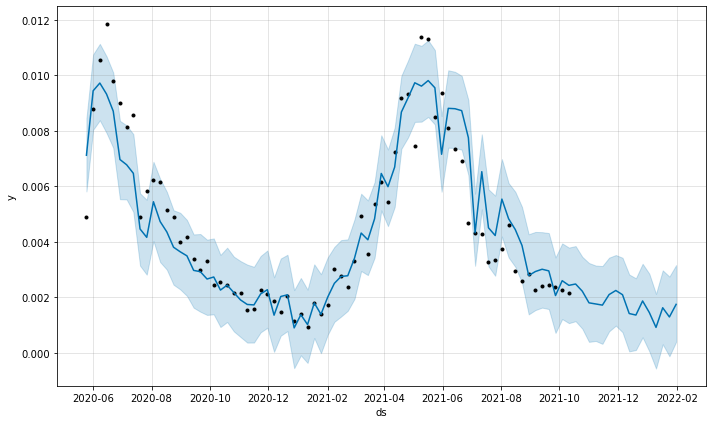

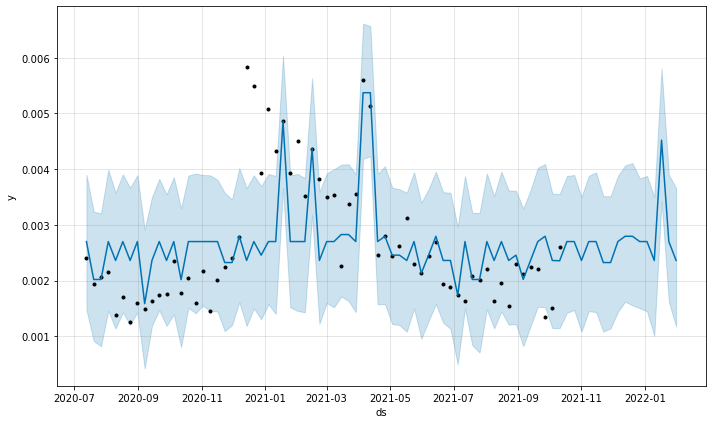

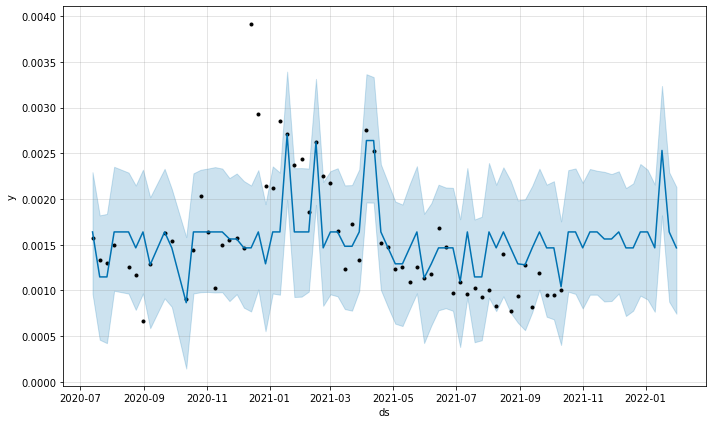

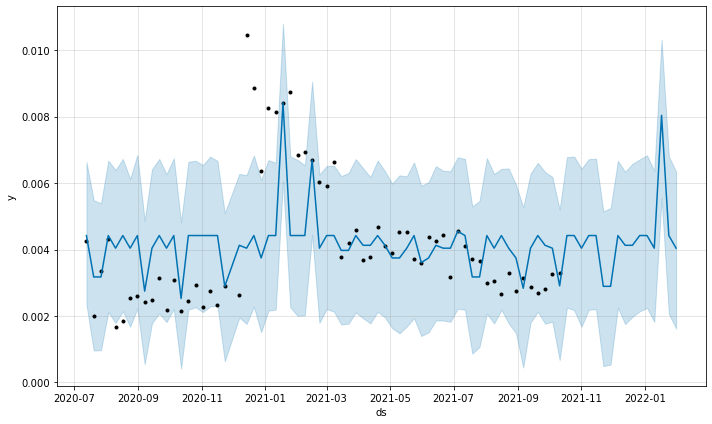

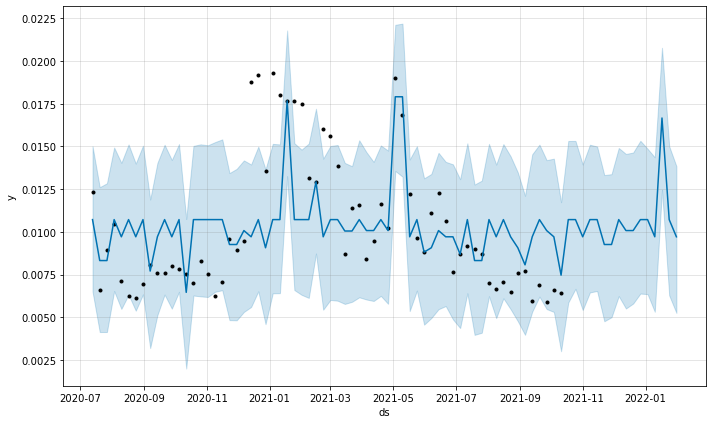

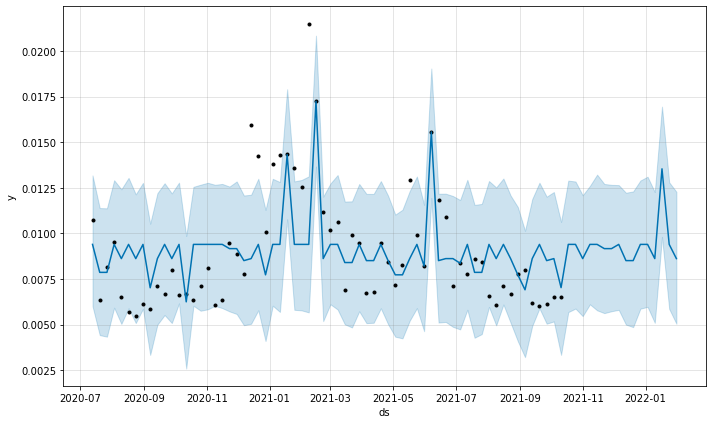

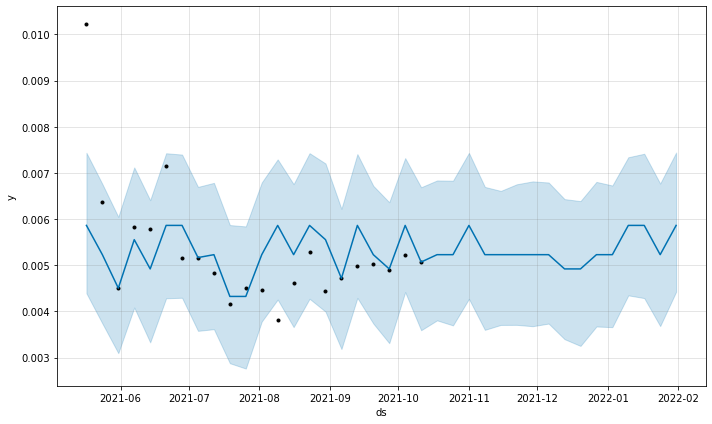

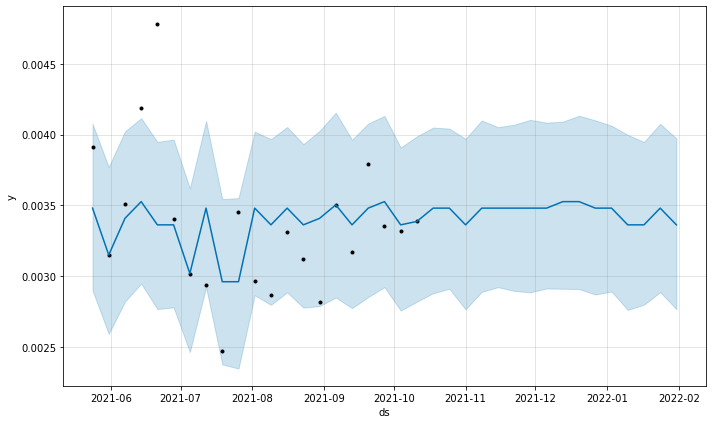

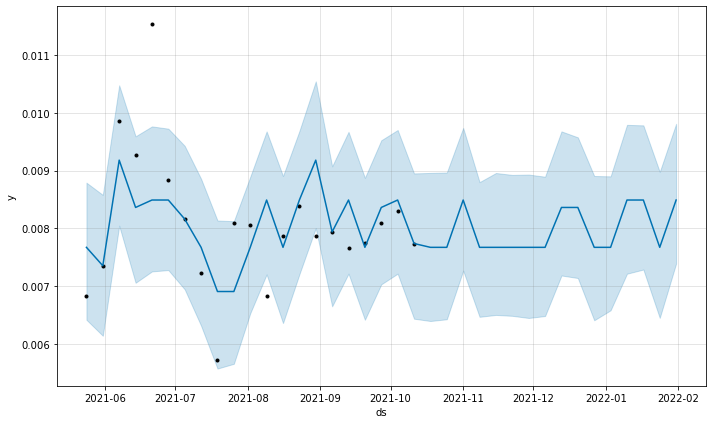

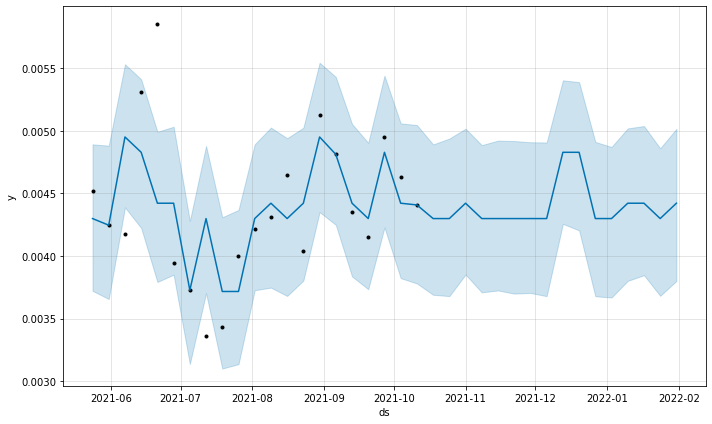

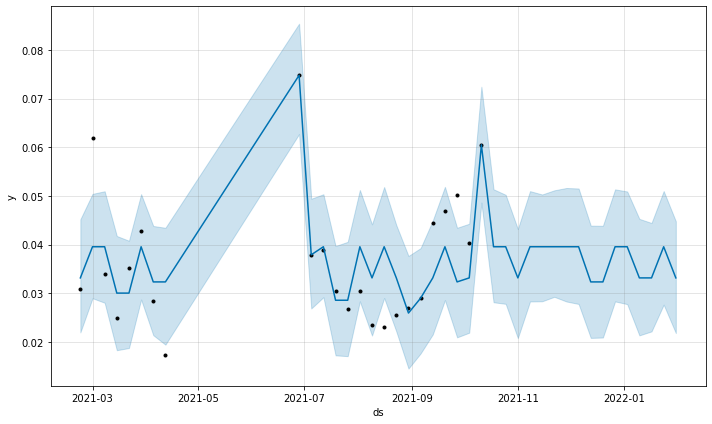

In [37]:
model_parameters = {
    'Indoor 2x3 Chenille'       :['2x3','Indoor','Chenille','Indoor','Chenille',False,0.01,'flat'],
    'Indoor 2.5x7 Chenille'     :['2.5x7','Indoor','Chenille','Indoor','Chenille',False,0.05,'linear'],
    'Indoor 2.5x10 Chenille'    :['2.5x10','Indoor','Chenille','Indoor','Chenille',True,0.05,'linear'],
    'Indoor 3x5 Chenille'       :['3x5','Indoor','Chenille','Indoor','Chenille',True,0.05,'linear'],
    'Indoor 5x7 Chenille'       :['5x7','Indoor','Chenille','Indoor','Chenille',False,0.15,'linear'],
    'Indoor 6x9 Chenille'       :['6x9','Indoor','Chenille','Indoor','Chenille',False,0.15,'linear'],
    'Indoor 8x10 Chenille'      :['8x10','Indoor','Chenille','Indoor','Chenille',False,0.15,'linear'],
    'Indoor 9x12 Chenille'      :['9x12','Indoor','Chenille','Indoor','Chenille',False,0.05,'flat'],
    'Indoor 6" Round Chenille'  :['6" Round','Indoor','Chenille','Indoor','Chenille',False,0.05,'flat'],
    'Indoor 8" Round Chenille'  :['8" Round','Indoor','Chenille','Indoor','Chenille',False,0.05,'flat'],
    'Outdoor 2.5x7 Chenille'    :['2.5x7','Outdoor','Chenille','Outdoor','Chenille',True,0.06,'flat'],
    'Outdoor 2.5x10 Chenille'   :['2.5x10','Outdoor','Chenille','Outdoor','Chenille',True,0.06,'flat'],
    'Outdoor 3x5 Chenille'      :['3x5','Outdoor','Chenille','Outdoor','Chenille',True,0.05,'flat'],
    'Outdoor 5x7 Chenille'      :['5x7','Outdoor','Chenille','Outdoor','Chenille',True,0.05,'flat'],
    'Outdoor 6x9 Chenille'      :['6x9','Outdoor','Chenille','Outdoor','Chenille',True,0.05,'flat'],
    'Outdoor 8x10 Chenille'     :['8x10','Outdoor','Chenille','Outdoor','Chenille',True,0.05,'flat'],
    'Indoor 2.5x7 Plush'        :['2.5x7','Indoor','Plush','Indoor','Chenille',False,0.05,'flat'],
    'Indoor 2.5x10 Plush'       :['2.5x10','Indoor','Plush','Indoor','Chenille',False,0.05,'flat'],
    'Indoor 3x5 Plush'          :['3x5','Indoor','Plush','Indoor','Chenille',False,0.01,'flat'],
    'Indoor 5x7 Plush'          :['5x7','Indoor','Plush','Indoor','Chenille',False,0.01,'flat'],
    'Indoor 6x9 Plush'          :['6x9','Indoor','Plush','Indoor','Chenille',False,0.01,'flat'],
    'Outdoor 2.5x7 Jute'        :['2.5x7','Outdoor','Jute','Indoor','Chenille',False,0.05,'flat'],
    'Outdoor 2.5x10 Jute'       :['2.5x10','Outdoor','Jute','Indoor','Chenille',False,0.05,'flat'],
    'Outdoor 3x5 Jute'          :['3x5','Outdoor','Jute','Indoor','Chenille',False,0.05,'flat'],
    'Outdoor 5x7 Jute'          :['5x7','Outdoor','Jute','Indoor','Chenille',False,0.05,'flat'],
    'Doormat 2x3 Bristle'       :['2x3','Doormat','Bristle','Indoor','Chenille',False,0.05,'flat']
}

df_forecasts = pd.DataFrame(columns = ['ds','yhat','y','y_merged','size'])

for i in model_parameters.items():
    print("fitting model for {}".format(i[0]))
    df = df_sales_FTS.loc[(df_sales_FTS['function']==i[1][1]) &
                          (df_sales_FTS['texture']==i[1][2]) &
                          (df_sales_FTS['size']==i[1][0])].rename(columns={'week_begin_date':'ds',
                                                                        'percent_of_total':'y'})
    df_input = df_Chenille.loc[(df_Chenille['function']==i[1][3]) &
                               (df_Chenille['texture']==i[1][4]),
                               ['ds','merged']].rename(columns={'merged':'percent_of_total_input'})
    df = df.merge(df_input, how='inner', on='ds')
    # specify model parameters
    m = Prophet(yearly_seasonality=i[1][5],
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=i[1][6],
                growth=i[1][7])
    # add holidays and regressors
    m.add_country_holidays(country_name='US')
    #m.add_regressor('percent_of_total_input',mode='multiplicative')
    m.add_regressor('sale',mode='multiplicative')
    m.add_regressor('launch',mode='multiplicative')
    m.add_regressor('bfcm',mode='multiplicative')
    m.add_regressor('anniversary',mode='multiplicative')
    m.add_regressor('spring')
    #m.add_regressor('email')
    m.add_regressor(i[1][0])
    # train model
    m.fit(df)
    # make future df
    future = m.make_future_dataframe(periods=52,freq = 'W-MON')
    future = future.merge(df_event,left_on='ds', right_on='week_begin_date')
    future = future.merge(df_input, on='ds')
    # create forecast
    forecast = m.predict(future)
    fig = m.plot(forecast)
    # create df with forecasts
    df_outputs = forecast[['ds', 'yhat']]
    df_outputs = df_outputs.merge(df[['ds','y']], how='left', on='ds')
    df_outputs['y_merged'] = df_outputs.y.combine_first(df_outputs.yhat)
    df_outputs['size'] = i[1][0]
    df_outputs['function'] = i[1][1]
    df_outputs['texture'] = i[1][2]
    df_forecasts = df_forecasts.append(df_outputs)
    print("-"*25)

In [38]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,sale,multiplicative,0.0,-1.827808e-01,-1.827808e-01,-1.827808e-01
1,launch,multiplicative,0.0,-1.619402e-01,-1.619402e-01,-1.619402e-01
2,bfcm,multiplicative,0.0,3.884770e-13,3.884770e-13,3.884770e-13
3,anniversary,multiplicative,0.0,-9.529970e-02,-9.529970e-02,-9.529970e-02
4,spring,additive,0.0,-2.300004e-03,-2.300004e-03,-2.300004e-03
5,2x3,additive,0.0,4.163865e-02,4.163865e-02,4.163865e-02


## Loop Through more Volatile Categories (Pads and certain size + texture combos)

INFO:prophet:n_changepoints greater than number of observations. Using 12.


fitting model for Indoor 2x3 Plush


INFO:prophet:n_changepoints greater than number of observations. Using 11.


-------------------------
fitting model for Pad Only 2x3
-------------------------
fitting model for Pad Only 2.5x7
-------------------------
fitting model for Pad Only 2.5x10
-------------------------
fitting model for Pad Only 3x5
-------------------------
fitting model for Pad Only 5x7
-------------------------
fitting model for Pad Only 6x9
-------------------------
fitting model for Pad Only 8x10
-------------------------
fitting model for Pad Only 9x12


INFO:prophet:n_changepoints greater than number of observations. Using 10.


-------------------------
fitting model for Pad Only 6" Round


INFO:prophet:n_changepoints greater than number of observations. Using 3.


-------------------------
fitting model for Pad Only 8" Round
-------------------------


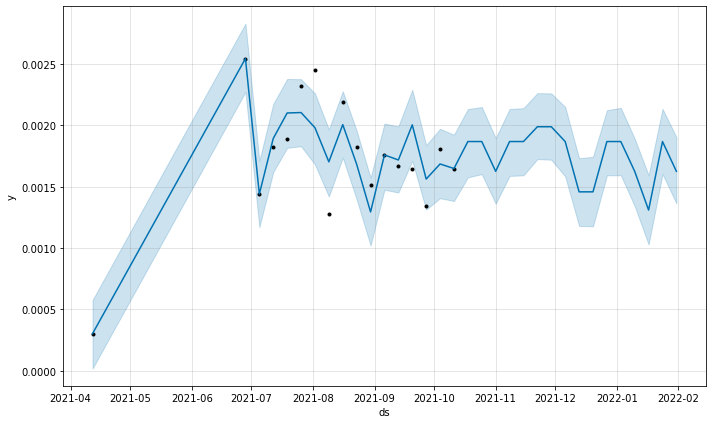

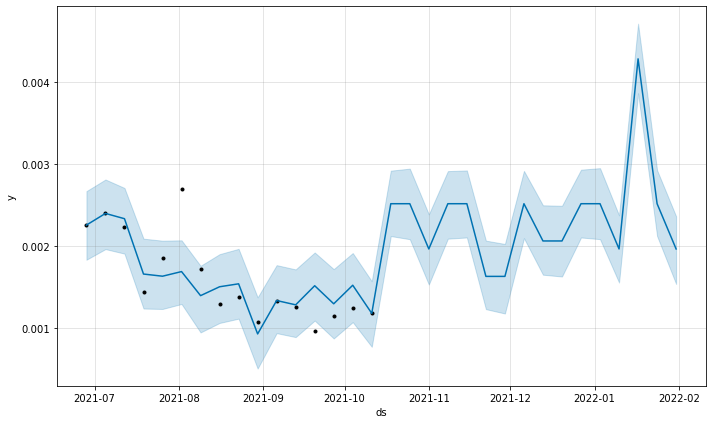

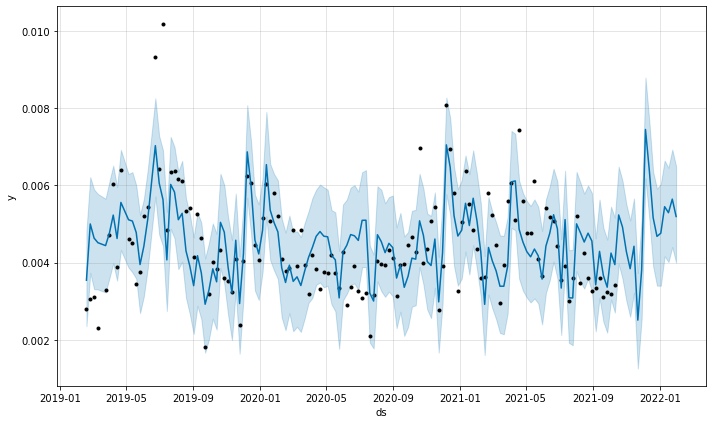

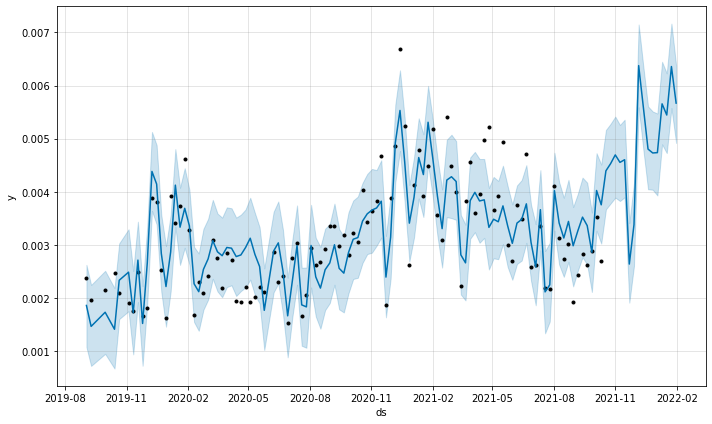

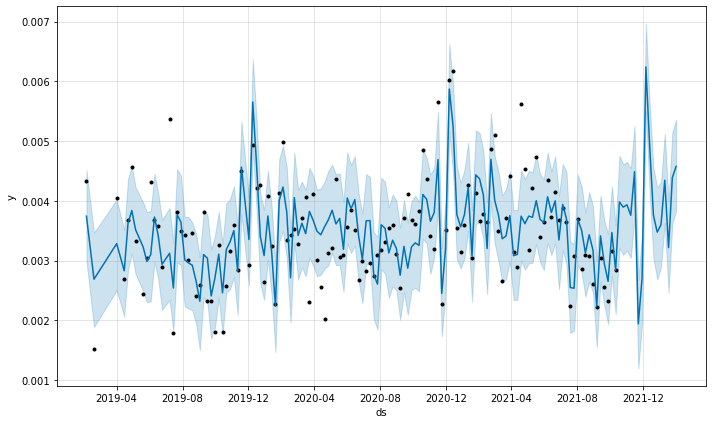

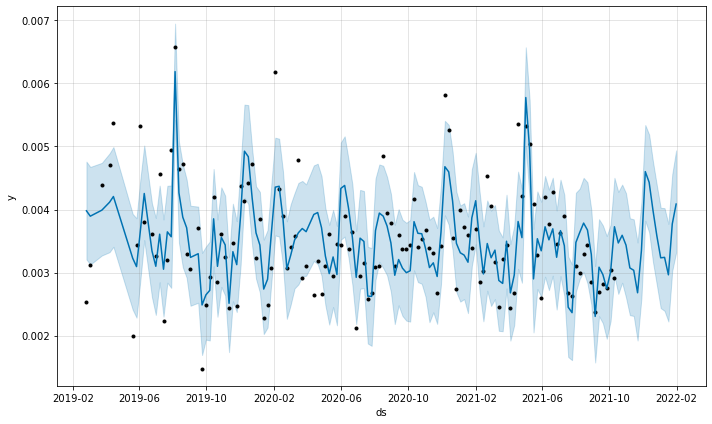

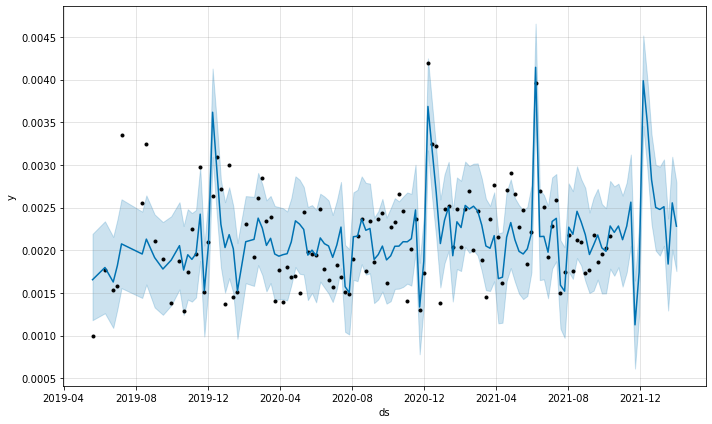

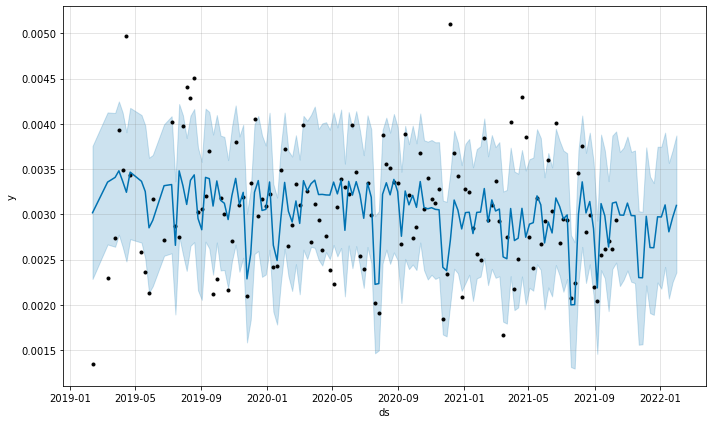

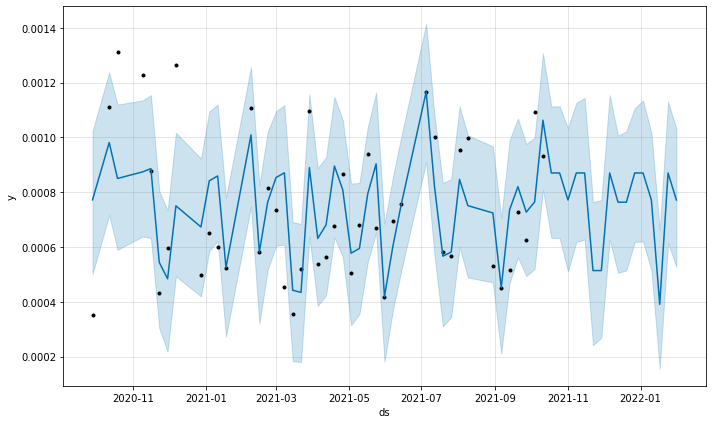

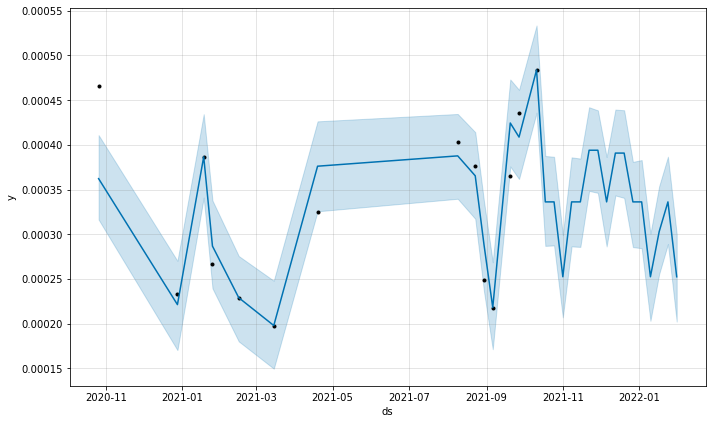

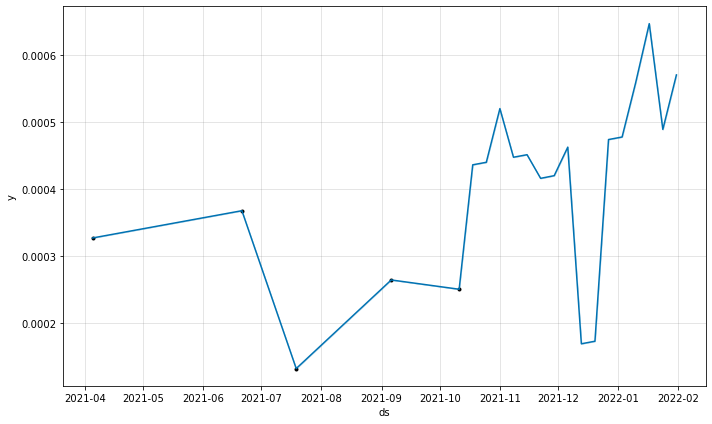

In [56]:
model_parameters = {
    'Indoor 2x3 Plush'  :['2x3','Indoor','Plush','3x5','Indoor','Plush',False,0.9,'flat'],
    'Pad Only 2x3'      :['2x3','NUL','Rubber pad','3x5','Indoor','Plush',False,0.2,'flat'],
    'Pad Only 2.5x7'    :['2.5x7','NUL','Rubber pad','2.5x7','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 2.5x10'   :['2.5x10','NUL','Rubber pad','2.5x10','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 3x5'      :['3x5','NUL','Rubber pad','3x5','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 5x7'      :['5x7','NUL','Rubber pad','5x7','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 6x9'      :['6x9','NUL','Rubber pad','6x9','Indoor','Chenille',True,0.05,'linear'],
    'Pad Only 8x10'     :['8x10','NUL','Rubber pad','8x10','Indoor','Chenille',False,0.05,'flat'],
    'Pad Only 9x12'     :['9x12','NUL','Rubber pad','9x12','Indoor','Chenille',False,0.05,'flat'],
    'Pad Only 6" Round' :['6" Round','NUL','Rubber pad','6" Round','Indoor','Chenille',False,0.01,'flat'],
    'Pad Only 8" Round' :['8" Round','NUL','Rubber pad','5x7','Indoor','Chenille',False,0.5,'flat']
}

for i in model_parameters.items():
    print("fitting model for {}".format(i[0]))
    df       = df_sales_FTS.loc[(df_sales_FTS['function']==i[1][1]) &
                                (df_sales_FTS['texture']==i[1][2]) &
                                (df_sales_FTS['size']==i[1][0])].rename(columns={'week_begin_date':'ds',
                                                                                 'percent_of_total':'y'})
    df_input = df_forecasts.loc[(df_forecasts['function']==i[1][4]) &
                                (df_forecasts['texture']==i[1][5]) &
                                (df_forecasts['size']==i[1][3]),
                                ['ds','y_merged']].rename(columns={'y_merged':'input_ts'})
    df = df.merge(df_input, how='inner', on='ds')

    df['floor'] = 0.0001

    # specify model parameters
    m = Prophet(yearly_seasonality=i[1][6],
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=i[1][7],
                growth=i[1][8])
    # add holidays and regressors
    m.add_country_holidays(country_name='US')
    m.add_regressor('sale',mode='multiplicative')
    m.add_regressor('launch',mode='multiplicative')
    m.add_regressor('bfcm',mode='multiplicative')
    m.add_regressor('anniversary',mode='multiplicative')
    m.add_regressor('spring')
    m.add_regressor('email')
    m.add_regressor('input_ts')
    m.add_regressor(i[1][0])
    # train model
    m.fit(df)
    # make future df
    future = m.make_future_dataframe(periods=52,freq = 'W-MON')
    future = future.merge(df_event,left_on='ds', right_on='week_begin_date')
    future = future.merge(df_input, on='ds')
    future['floor'] = 0.0001
    # create forecast
    forecast = m.predict(future)
    fig = m.plot(forecast)
    # create df with forecasts
    df_outputs = forecast[['ds', 'yhat']]
    df_outputs = df_outputs.merge(df[['ds','y']], how='left', on='ds')
    df_outputs['y_merged'] = df_outputs.y.combine_first(df_outputs.yhat)
    df_outputs['size'] = i[1][0]
    df_outputs['function'] = i[1][1]
    df_outputs['texture'] = i[1][2]
    df_forecasts = df_forecasts.append(df_outputs)
    print("-"*25)

## Make adjustments and push to DW

In [58]:
# setting to average
avg_forecast1 = df_forecasts.loc[(df_forecasts['size']=='8" Round') &
                       (df_forecasts['function']=='NUL') &
                       (df_forecasts['texture']=='Rubber pad') &
                       (df_forecasts['y'].notnull()),
                       ['y']].copy().apply(np.average, axis=0)
                 
df_forecasts['y_merged'] = np.where((df_forecasts['size'] == '8" Round') &
                                    (df_forecasts['function'] == 'NUL') &
                                    (df_forecasts['texture'] == 'Rubber pad') &
                                    (np.isnan(df_forecasts['y'])), 
                                    avg_forecast1.values,df_forecasts.y_merged.values)
avg_forecast2 = df_forecasts.loc[(df_forecasts['size']=='2x3') &
                       (df_forecasts['function']=='Indoor') &
                       (df_forecasts['texture']=='Plush') &
                       (df_forecasts['y'].notnull()),
                       ['y']].copy().apply(np.average, axis=0)
                 
df_forecasts['y_merged'] = np.where((df_forecasts['size'] == '2x3') &
                                    (df_forecasts['function'] == 'Indoor') &
                                    (df_forecasts['texture'] == 'Plush') &
                                    (np.isnan(df_forecasts['y'])), 
                                    avg_forecast2.values,df_forecasts.y_merged.values)

In [59]:
df_forecasts.loc[(df_forecasts['size']=='8" Round') &
                       (df_forecasts['function']=='NUL') &
                       (df_forecasts['texture']=='Rubber pad')].sort_values(by=['ds'])

,ds,yhat,y,y_merged,size,function,texture
0,2021-04-05,0.000327,0.000327,0.000327,"8"" Round",NUL,Rubber pad
1,2021-06-21,0.000368,0.000368,0.000368,"8"" Round",NUL,Rubber pad
2,2021-07-19,0.000133,0.000133,0.000133,"8"" Round",NUL,Rubber pad
3,2021-09-06,0.000265,0.000265,0.000265,"8"" Round",NUL,Rubber pad
4,2021-10-11,0.000251,0.000251,0.000251,"8"" Round",NUL,Rubber pad
5,2021-10-18,0.000436,NaN,0.000269,"8"" Round",NUL,Rubber pad
6,2021-10-25,0.000440,NaN,0.000269,"8"" Round",NUL,Rubber pad
7,2021-11-01,0.000520,NaN,0.000269,"8"" Round",NUL,Rubber pad
8,2021-11-08,0.000448,NaN,0.000269,"8"" Round",NUL,Rubber pad
9,2021-11-15,0.000452,NaN,0.000269,"8"" Round",NUL,Rubber pad


In [83]:
today = date.today()

In [84]:
(today-timedelta(days=today.weekday())).strftime("%Y-%m-%d")

'2021-10-18'

In [85]:
forecast_begin_date = (today-timedelta(days=today.weekday())).strftime("%Y-%m-%d")
df_gdf =df_forecasts.loc[(df_forecasts['ds'] >= forecast_begin_date),
                         ['ds',
                          'y_merged',
                          'size',
                          'function',
                          'texture'
                         ]].rename(columns={'ds':'horizon_date',
                                            'y_merged':'forecasted_percent_of_total'})
df_gdf['created_date'] = (today-timedelta(days=today.weekday())).strftime("%Y-%m-%d")
df_gdf.sort_values(by=['function','texture','size','horizon_date','created_date'],inplace=True)

In [86]:
df_gdf.loc[df_gdf['created_date']== (today-timedelta(days=today.weekday())).strftime("%Y-%m-%d")] #(today-timedelta(days=today.weekday())).strftime("%Y-%m-%d")]

,horizon_date,forecasted_percent_of_total,size,function,texture,created_date
24,2021-10-18,0.040005,2x3,Doormat,Bristle,2021-10-18
25,2021-10-25,0.040005,2x3,Doormat,Bristle,2021-10-18
26,2021-11-01,0.033207,2x3,Doormat,Bristle,2021-10-18
27,2021-11-08,0.040005,2x3,Doormat,Bristle,2021-10-18
28,2021-11-15,0.040005,2x3,Doormat,Bristle,2021-10-18
...,...,...,...,...,...,...
32,2022-01-03,0.004319,5x7,Outdoor,Jute,2021-10-18
33,2022-01-10,0.004573,5x7,Outdoor,Jute,2021-10-18
34,2022-01-17,0.004573,5x7,Outdoor,Jute,2021-10-18
35,2022-01-24,0.004319,5x7,Outdoor,Jute,2021-10-18


In [87]:
# count check
len(df_gdf[['size','function','texture']].value_counts())

37

In [88]:
df_gdf.tail()

,horizon_date,forecasted_percent_of_total,size,function,texture,created_date
32,2022-01-03,0.004319,5x7,Outdoor,Jute,2021-10-18
33,2022-01-10,0.004573,5x7,Outdoor,Jute,2021-10-18
34,2022-01-17,0.004573,5x7,Outdoor,Jute,2021-10-18
35,2022-01-24,0.004319,5x7,Outdoor,Jute,2021-10-18
36,2022-01-31,0.004573,5x7,Outdoor,Jute,2021-10-18


In [89]:
df_gdf.to_sql('gdf_outputs_test', engine, schema = 'temp_entities', index=False, if_exists='append', method='multi')

In [44]:
df_gdf.head()

,horizon_date,forecasted_percent_of_total,size,function,texture,created_date
20,2021-09-20,0.031550,2x3,Doormat,Bristle,2021-09-20
21,2021-09-27,0.030282,2x3,Doormat,Bristle,2021-09-20
22,2021-10-04,0.033476,2x3,Doormat,Bristle,2021-09-20
23,2021-10-11,0.031537,2x3,Doormat,Bristle,2021-09-20
24,2021-10-18,0.030698,2x3,Doormat,Bristle,2021-09-20
